---
format: 
  html:
    toc: false
    page-layout: full
    code-fold: true
    code-tools: true
execute:
    echo: true
    warning: false
---

# 4) Clustering by Features
## NFIP K-means Clustering and Blue Acres Spatial Cluster Overlay

Using the NJ NFIP single family home claims data in conjunction with US Census Bureau American Community Survey (ACS) data, a k-means clustering analyis is used to identify tracts with similar features and label these clusters based on their similar characteristics.

In [114]:
#| output: false

# packages
import geopandas as gpd
import holoviews as hv
import hvplot.pandas
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import cenpy
import pygris
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# options
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
pd.options.display.float_format = '{:.2f}'.format

This data comes from the NFIP redacted claims data set that was filtered for New Jersey, as descibed on the NFIP Data Processing page. New Jersey tracts boundaries are downloaded using the pygris package. 

Because ACS 5-year estimates are used for economic and demographic characteristics and Census tract geography may change every 10 years when a new Census occurs, single family homes claims data is filtered to include claims between 2010 and 2014. This data was chosen due to the high number of claims that occured in time period from both Hurricane Irene and Hurricane Sandy while matching a range for the ACS 5-year estimates with consistent Census geographies.

In [115]:
#| output: false

# reads data and does preprocessing steps
claims_NJ = pd.read_csv("data/claims_sfh.csv")
claims_NJ['countyCode'] = claims_NJ['countyCode'].astype(str).str.rstrip('.0')
claims_NJ['censusTract'] = claims_NJ['censusTract'].astype(str).str.rstrip('.0')
claims_NJ['censusBlockGroupFips'] = claims_NJ['censusBlockGroupFips'].astype(str).str.rstrip('.0')
claims_NJ['yearOfLoss'] = pd.to_datetime(claims_NJ['yearOfLoss'], format='%Y').dt.year

claims_NJ = claims_NJ[(claims_NJ['yearOfLoss'] >= 2010) & (claims_NJ['yearOfLoss'] <= 2014)] 

# download administrative boundaries for mapping from pygris
NJ_tracts = pygris.tracts(state="NJ", year=2014)

Using FIPS code '34' for input 'NJ'


Claims are aggregating per Census tracts using the average building damage amount and total property value, as well as the sum of total claims for the Census tract, then joined to the tract information from pygris.

In [116]:

# helper functions for aggregating data
agg_functions = {
    'buildingDamageAmount': 'mean',
    'observation': 'sum',
}

# groups by tract and uses helper functions
claims_by_tract = claims_NJ.groupby(["censusTract"]).agg(agg_functions).reset_index()

# reduces df to necessary columns 
claims_by_tract.columns = ['censusTract',
                           'mean_amountbuildingDamageAmount',
                           'observation']

# fills in tracts with missing ending 0s (compared length to GEOID and naming conventions)
claims_by_tract['censusTract'] = claims_by_tract['censusTract'].astype(str).str.pad(width=11, side='right', fillchar='0')

# joins claims to tracts data
NJ_tracts_join = claims_by_tract.merge(
    NJ_tracts,
    left_on=["censusTract"],
    right_on=["GEOID"]
)

The Census API is accessed to acquire 5-year estimate data tied to 2014. Variables of interest include the total population of a tract, the number of residents that are non-hispanic white, and the median household income in the past 12 months. The population variables are used to calculate the percentage of white residents per Census tracts - the purpose of using this variable is to identify if there are any demographic trends to claims or areas with a high presence of Blue Acres parcels. The data is then merged with the claims data (average damage and property value for single family homes claims).

In [117]:
# accesses API for ACS 5yr 2019
acs = cenpy.remote.APIConnection("ACSDT5Y2014")

# defines variables of interest
variables = [
    "NAME",
    "B03002_001E", # Total
    "B03002_003E", # Not Hispanic, White
    "B19013_001E", # Median Household Income in Past 12 Months
]

# accesses API for Census
NJ_acs = acs.query(
    cols=variables,
    geo_unit="tract:*",
    geo_filter={"state": "34", "county": "*"},
)

# Concats parts of GEOID
NJ_acs['GEOID'] = NJ_acs['state'].astype(str) + NJ_acs['county'].astype(str) + NJ_acs['tract'].astype(str)

# Converts values from strings to floats
for variable in variables:
    # Convert all variables EXCEPT for NAME
    if variable != "NAME":
        NJ_acs[variable] = NJ_acs[variable].astype(float)
        
# joins tracts data with ACS data
NJ_tracts_cluster = NJ_tracts_join.merge(
    NJ_acs,
    left_on=["censusTract"],
    right_on=["GEOID"],
)

# Renames columns
NJ_tracts_cluster = NJ_tracts_cluster.rename(
    columns={
        "censusTract" : "tractID",
        "B03002_001E": "TotalPop", 
        "B03002_003E": "WhiteAlone",  
        "B19013_001E": "MedInc",  
    }
)

# Calculates percent of population that's white alone
NJ_tracts_cluster["pctWhite"] = NJ_tracts_cluster["WhiteAlone"]/NJ_tracts_cluster["TotalPop"]* 100

# simplified cluster df
NJ_cluster_data = NJ_tracts_cluster.loc[:, (
    "tractID",
    "mean_amountbuildingDamageAmount",
    "MedInc",
    "pctWhite",
    "TotalPop",
    "observation"
)].dropna()


The variables of interest are scaled due to the differences in ranges between variables - because k-means is a distance-based algorithm, scaling the data ensures that the variable with the largest range of values is not weighted differently than others with smaller ranges of values. 

Additionally, the kneedle algorithm is used to derive the optimal number of clusters based on identifying a hinge point that appears to show dimishing returns past that point. Based on the plot, this inflection point appears to be five clusters. The k-means analysis is then run on the scaled data with five clusters set as the parameter

D:\Python\envs\musa-550-fall-2023\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
D:\Python\envs\musa-550-fall-2023\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
D:\Python\envs\musa-550-fall-2023\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
D:\Python\envs\musa-550-fall-2023\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is k

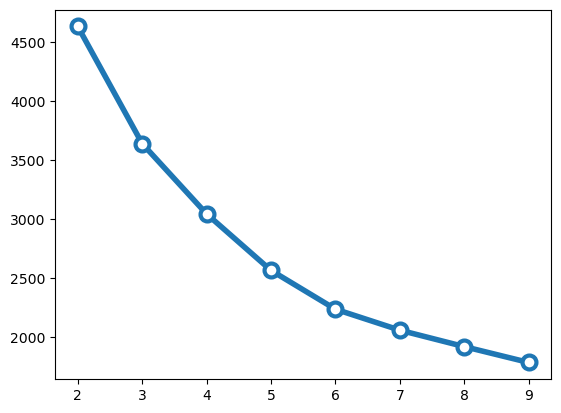

In [118]:
# scales data for kmeans clustering
claims_scaled = scaler.fit_transform(
    NJ_cluster_data[["mean_amountbuildingDamageAmount",
                     "MedInc",
                     "pctWhite",
                     "TotalPop",
                     "observation"
                    ]])

# Number of clusters to try out
n_clusters = list(range(2, 10))

# Run kmeans for each value of k
inertias = []
for k in n_clusters:
    
    # Initialize and run
    kmeans = KMeans(n_clusters=k, random_state=22, n_init=10)
    kmeans.fit(claims_scaled)
    
    # Save the "inertia"
    inertias.append(kmeans.inertia_)
    
# Plots knee graph
plt.plot(n_clusters, inertias, marker='o', ms=10, mfc='white', lw=4, mew=3);

In [119]:
# runs kmeans with five clusters
kmeans = KMeans(n_clusters=5, random_state=22, n_init=10)

# fits to scaled data
kmeans.fit(claims_scaled)

# adds labels to starting df
NJ_cluster_data['label'] = kmeans.labels_

# adds cluster categories
cluster_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E',}
NJ_cluster_data['Cluster'] = NJ_cluster_data['label'].map(cluster_map)

# groups by label
cluster_size = NJ_cluster_data.groupby('label', as_index=False).size()

D:\Python\envs\musa-550-fall-2023\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


The cluster analysis sorted the 1166 Census tracts with NFIP claims during the analysis dates to find optimal clusters based on the included variables. While all clusters averaged at least 21 claims per tract, the cluster associated with label 3 was hit especially hard by claims in this time period.

In [120]:
# calculates means by label
cluster_summary = NJ_cluster_data.groupby("label", as_index=False)[
    ["mean_amountbuildingDamageAmount",
     "MedInc", 
     "pctWhite",
     "TotalPop",
     "observation"
    ]].mean()

# merges cluster size
cluster_summary = cluster_summary.merge(cluster_size)

# outputs chart of cluster results
cluster_summary

,label,mean_amountbuildingDamageAmount,MedInc,pctWhite,TotalPop,observation,size
0,0,13431.15,114530.75,74.37,6333.91,20.97,375
1,1,67609.47,84987.63,81.07,4271.48,123.08,97
2,2,12782.96,52600.81,26.61,4383.97,23.97,264
3,3,50503.18,80140.19,92.62,3539.89,1408.04,27
4,4,16023.57,80599.71,77.91,3484.60,44.44,403


In [121]:
# Normalizes data
cluster_summary_normalized = (cluster_summary - cluster_summary.min()) / (cluster_summary.max() - cluster_summary.min())

#cluster_summary_normalized

These values are then normalized on a scale of 0 to 1. Normalized results show the relative differences in categories across clusters to support interpretability.

In [122]:
# remaps categories
cluster_map = {0: 'A', .25: 'B', .50: 'C', .75: 'D', 1: 'E',}
cluster_summary_normalized['cluster'] = cluster_summary_normalized['label'].map(cluster_map)

# renames columns
cluster_summary_normalized_final = cluster_summary_normalized.rename(columns={
    "mean_amountbuildingDamageAmount": "Bldg_Dmg",
    "mean_buildingPropertyValue" : "Bldg_Val",
    "MedInc": "MedHHInc",
    "pctWhite": "PctWhite",
    "observation": "Claims",
    "cluster" : "Cluster"
}).drop(['label', 'size'], axis=1).sort_values(by='Cluster')

# outputs chart of normalized cluster results
cluster_summary_normalized_final

,Bldg_Dmg,MedHHInc,PctWhite,TotalPop,Claims,Cluster
0,0.01,1.00,0.72,1.00,0.00,A
1,1.00,0.52,0.83,0.28,0.07,B
2,0.00,0.00,0.00,0.32,0.00,C
3,0.69,0.44,1.00,0.02,1.00,D
4,0.06,0.45,0.78,0.00,0.02,E


To further aid in interpretability, normalized values of each cluster are plotted to compare across clusters. 

While there are several factors in each cluster, some high level generalizations can be made about the Census tracts in each cluster during the analysis period of 2010-2014:

* Cluster A: Wealthy, Populous, Lower Impact Flooding
* Cluster B: High Impact Flooding
* Cluster C: Lower Income, Non-White, Lower Impact Flooding
* Cluster D: Sparsely Populated, High Impact Flooding
* Cluster E: Sparsely Populated, Low Impact Flooding

::: {.callout-important}
The following plot inconsistently renders to the website, but loads in a Jupyter notebook - investigating underlying issue.
:::

In [197]:
# creates clustered bar chart of normalized cluster results
clustered_bar_plot = cluster_summary_normalized_final.hvplot.bar(
    x='Cluster',
    y=['Bldg_Dmg', 'MedHHInc', 'PctWhite', "Claims", "TotalPop"],
    xlabel='Cluster Label',
    ylabel='Normalized Average Values',
    rot = 45,
    title='Normalized Average Values by Cluster',
    width=1200, height=400,
    groupby=[],
)

# outputs bar plot
clustered_bar_plot

:Bars   [Cluster,Variable]   (value)

To identify if any spatial clusters of Blue Acres tracts were located within any of the features clusters of NFIP and ACS tracts, the results of the k-means clustering is added back to the spatial data.

In [124]:
# Merges cluster results with original df
NJ_cluster_data_join = NJ_cluster_data.merge(
    NJ_tracts,
    left_on=["tractID"],
    right_on=["GEOID"]

)

# converts merged results to gdf
NJ_cluster_data_join_map = gpd.GeoDataFrame(NJ_cluster_data_join, geometry=NJ_cluster_data_join['geometry']).to_crs("EPSG:4326")

The Blue Acres spatial clusters are loaded in, and tracts idenfied in the k-means clustering are joined to identify matches. 

The 10 spatial clusters are relatively evenly distributed across the k-means cluster groups:

* Two Blue Acres Spatial Clusters in Group A: Wealthy, Populous, Lower Impact Flooding
* Two Blue Acres Spatial Clusters in Group B: High Impact Flooding
* One Blue Acres Spatial Cluster in Group C: Lower Income, Non-White, Lower Impact Flooding
* Two Blue Acres Spatial Clusters in Group  D: Sparsely Populated, High Impact Flooding
* Three Blue Acres Spatial Cluster in Group E: Sparsely Populated, Low Impact Flooding

Given the differences in time span between the two clustering analyses (all Blue Acres properties since 1995 and only claims between 2010-2014), strong conclusions cannot be drawn from comparing the two. However, the results highlight that the Blue Acres Program appears to be active in supporting a range of communities based on the analysis variables across the state. 


In [125]:
# reads and preprocesses saved DBSCAN cluster file for Blue Acres
BA_clusters = pd.read_csv("data/BA_clusters_tracts.csv")
BA_clusters['GEOID'] = BA_clusters['GEOID'].astype(str)

# Converts DBSCAN results to gdf
BA_clusters = gpd.GeoDataFrame(
    BA_clusters,
    geometry=gpd.points_from_xy(BA_clusters["x"], BA_clusters["y"]),
    crs="EPSG:3424",
).to_crs("EPSG:4326")

# adds kmeans results to DBSCAN clusters data
BA_cluster_label = BA_clusters.merge(
    NJ_cluster_data_join, 
    left_on = "GEOID", 
    right_on = "tractID"
).groupby("Cluster").size().reset_index()

# renames column
BA_cluster_label = BA_cluster_label.rename(
    columns={
        0: "Count",
    }
)

BA_cluster_label

,Cluster,Count
0,A,2
1,B,2
2,C,1
3,D,2
4,E,3


The following map visualizes the results of the k-means clustering analysis spatially along with points representing the Blue Acres spatial clusters.

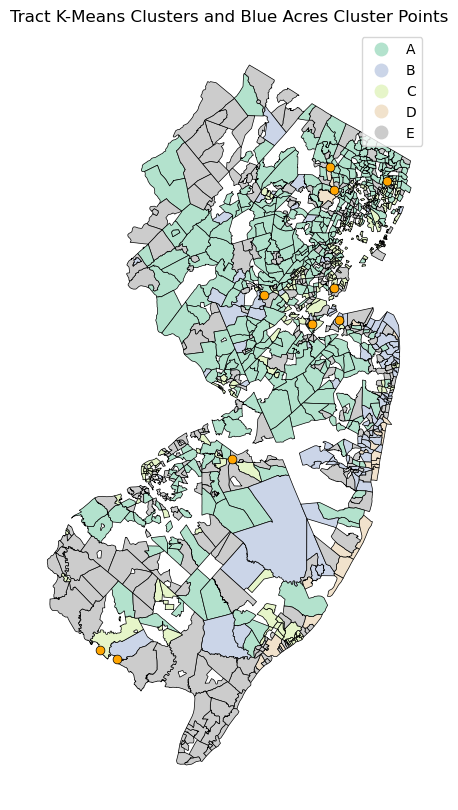

In [194]:
# Plots points of parcels and clusters side by side
f, ax = plt.subplots(figsize=(10, 10))

NJ_cluster_data_join_map.plot(ax=ax,
                              column="Cluster",
                              cmap="Pastel2",
                              edgecolor="black",
                              linewidth = .5,
                              legend=True)
                     
BA_clusters.plot(ax=ax, 
                 color='orange',
                 edgecolor="black",
                 linewidth = .5,
                 markersize=40)

ax.set_title('Tract K-Means Clusters and Blue Acres Cluster Points')
ax.set_axis_off()


Given the gaps in data, direct conclusions cannot be drawn from this analysis. The temporal aspect of the data and differing geographies across years at the more granular level present challenges for stronger results. However, the methods presented can provide useful avenues for more in-depth research into NFIP claims and Blue Acres data moving forward and are worth refining over time for this analysis.